# Test Keras random seed setting

This is a note on reducing randomness in model training in Keras. In the [official documentaion](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development), you can find a solution to fix the randomness.  In the following, I am trying to disentangle different contributions.

More investigation on the code level is needed to understand the full picture.  However, it is out of the scope of this work.
<!-- END_TEASER -->
**Note** - the running scripts in this notebook are for Bash.  For Windows users, you can still run the training scripts, but you can't run it multiple times as in this work.

In [1]:
# Set up
# Pre-requisite tensorflow, keras, matplotlib
import numpy as np
import matplotlib.pylab as plt
import matplotlib 
plt.style.use(['fivethirtyeight'])
%matplotlib inline

In [2]:
def plot(d):
    x = sorted(d.keys())
    mean_acc = [np.mean(d[i][:,1]) for i in x]
    std_acc = [np.std(d[i][:,1]) for i in x]
    mean_loss = [np.mean(d[i][:,0]) for i in x]
    std_loss = [np.std(d[i][:,0]) for i in x]

    fig = plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.errorbar(range(len(x)), mean_acc, std_acc, fmt='o', ecolor='r')
    plt.xticks(range(len(x)), x, rotation='45')
    plt.ylabel('accuracy')
    plt.subplot(122)
    plt.errorbar(range(len(x)), mean_loss, std_loss, fmt='o', ecolor='r')
    plt.xticks(range(len(x)), x, rotation='45')
    plt.ylabel('loss')
    plt.tight_layout()
    plt.show()

## Initial weights without training

Let's take a look of the prediction accuracy and loss before any training.  It mainly tells us whether the initial weights are same for different runs.

In [3]:
# not fix any seed
!rm -f no_train_no_seed_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py >> no_train_no_seed_fixed.csv 2>/dev/null; done

In [4]:
# fix numpy seed
!rm -f no_train_numpy_seed_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py -n 1 >> no_train_numpy_seed_fixed.csv 2>/dev/null; done

In [5]:
# fix numpy seed, but change tf random seed
!rm -f no_train_numpy_seed_fixed_diff_tf_seeds.csv
!for i in `seq 10`; do ./mnist_cnn.py -n 1 -t ${i} >> no_train_numpy_seed_fixed_diff_tf_seeds.csv 2>/dev/null; done

In [6]:
# fix numpy seed, but change random seed
!rm -f no_train_numpy_seed_fixed_diff_random_seeds.csv
!for i in `seq 10`; do ./mnist_cnn.py -n 1 -r ${i} >> no_train_numpy_seed_fixed_diff_random_seeds.csv 2>/dev/null; done

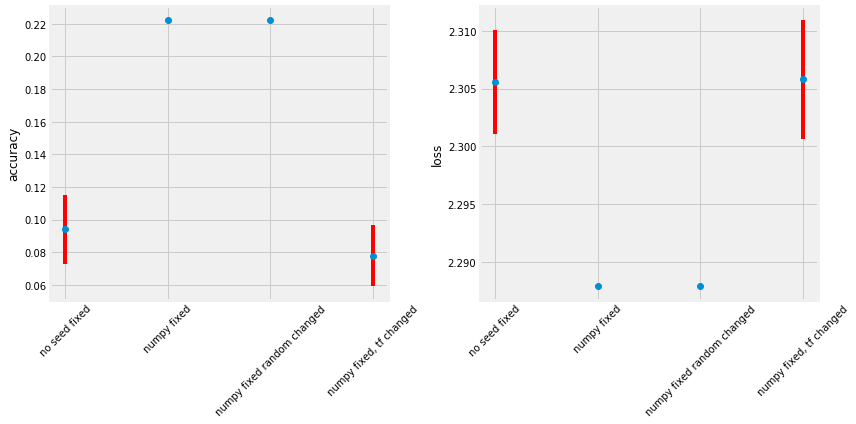

In [7]:
d = {}
d['no seed fixed']= np.loadtxt("no_train_no_seed_fixed.csv", delimiter=',')
d['numpy fixed'] = np.loadtxt("no_train_numpy_seed_fixed.csv", delimiter=',')
d['numpy fixed, tf changed'] = np.loadtxt("no_train_numpy_seed_fixed_diff_tf_seeds.csv", delimiter=',')
d['numpy fixed random changed'] = np.loadtxt("no_train_numpy_seed_fixed_diff_random_seeds.csv", delimiter=',')
plot(d)

### Conclusion

Using numpy random seed is typically sufficient to fix the initial weights of the model.
However, if you code uses tensorflow random generator somewhere, you might want to fix it too.


## After training 1 epochs

In [8]:
def get_history(filename, niter=10):
    d = {}
    for i in range(1, niter+1):
        d[i] = np.loadtxt(filename%i, skiprows=1, delimiter=',')
    return d

def plot_history(filename, niter=10):
    data = get_history(filename, niter=niter)
    fig = plt.figure(figsize=(16,8))
    plt.subplot(121)
    for i in range(1, niter+1):
        plt.plot(data[i], linewidth=1.0)
    plt.ylabel("trained batch loss")
    plt.xlabel("batches")
    plt.subplot(122)
    for i in range(1, niter+1):
        plt.plot(data[i]/data[1]-1, linewidth=1.0)
    plt.xlabel("batches")
    plt.ylabel("relative diff")
    plt.show()

In [9]:
# fix numpy seed, also not use data generator
!rm -f train_numpy_random_seed_fixed_w0.csv
!for i in `seq 10`; do ./mnist_cnn.py -f train_numpy_seed_fixed_w0_${i}.csv -e 1 -w 0 -n 2 -r ${i} >> train_numpy_seed_fixed_w0.csv 2>/dev/null; done

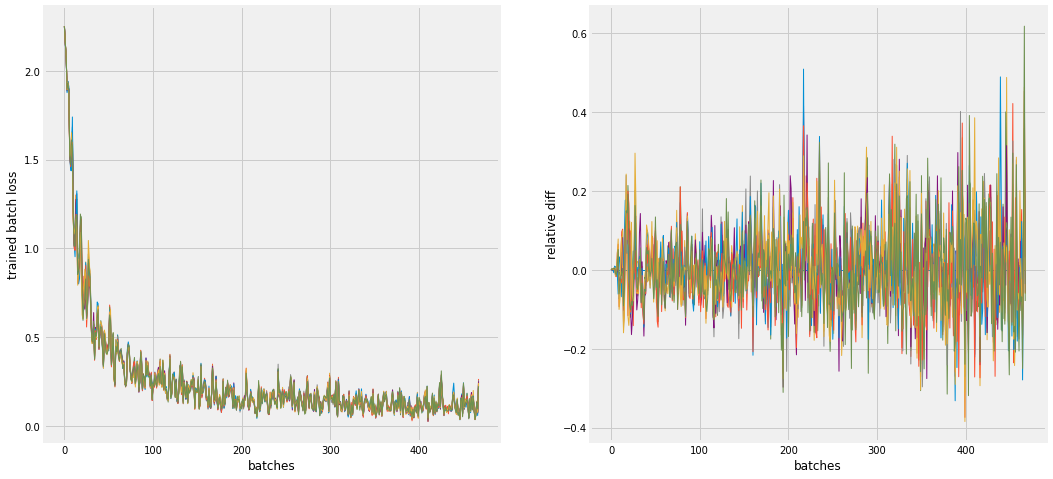

In [10]:
plot_history("train_numpy_seed_fixed_w0_%d.csv")

In [11]:
# not fix any seed
!rm -f train_no_seed_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py -f train_no_seed_fixed_${i}.csv -e 1 >> train_no_seed_fixed.csv 2>/dev/null; done

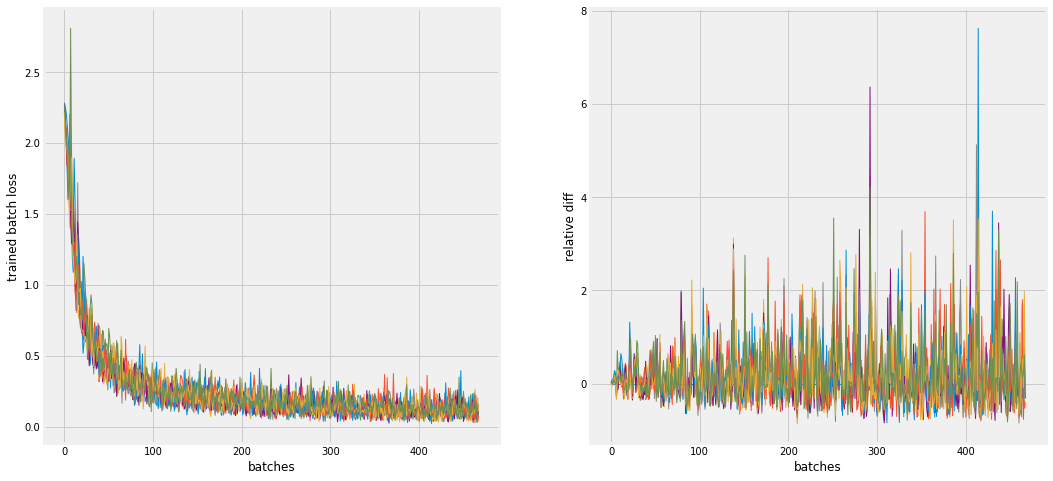

In [12]:
plot_history("train_no_seed_fixed_%d.csv")

In [13]:
# fix numpy seed
!rm -f train_numpy_seed_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py -f train_numpy_seed_fixed_${i}.csv -e 1 -n 1 >> train_numpy_seed_fixed.csv 2>/dev/null; done

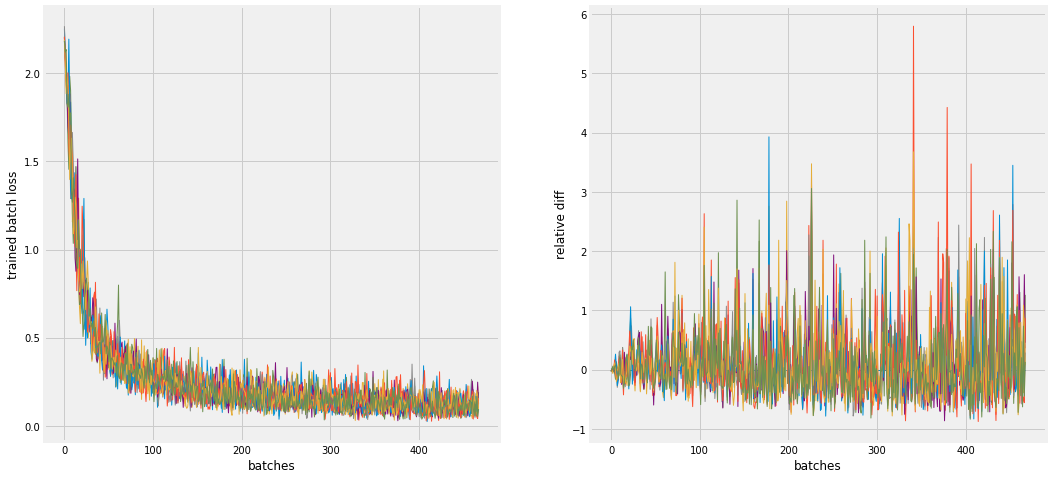

In [14]:
plot_history("train_numpy_seed_fixed_%d.csv")

In [15]:
# fix numpy, random, and tf seeds
!rm -f train_numpy_random_tf_seeds_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py -f train_numpy_random_tf_seeds_fixed_${i}.csv -e 1 -n 2 -r ${i} >> train_numpy_random_tf_seeds_fixed.csv 2>/dev/null; done

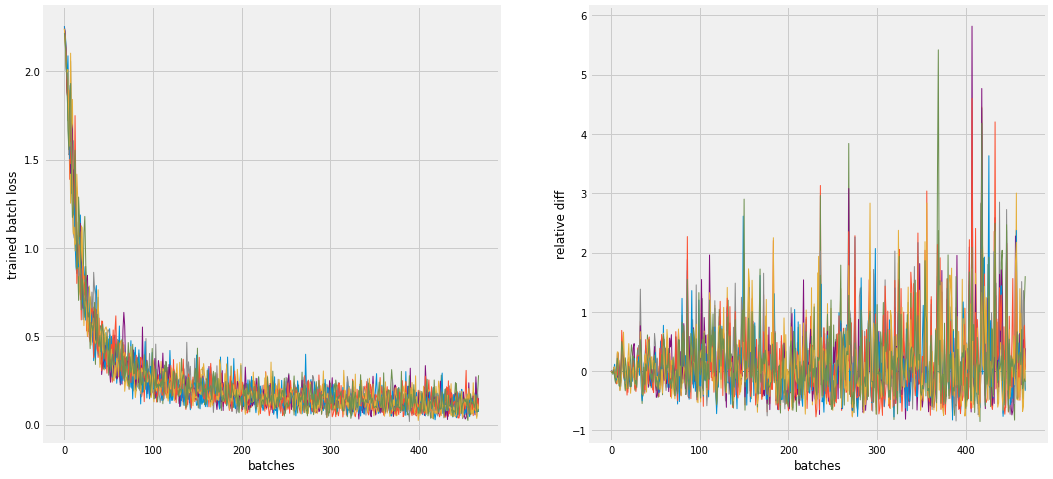

In [16]:
plot_history("train_numpy_random_tf_seeds_fixed_%d.csv")

In [17]:
# fix numpy, random, tf and hash seeds
!rm -f train_numpy_random_tf_hash_seeds_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py -f train_numpy_random_tf_hash_seeds_fixed_${i}.csv -e 1 -n 2 -r ${i} >> train_numpy_random_tf_hash_seeds_fixed.csv 2>/dev/null; done

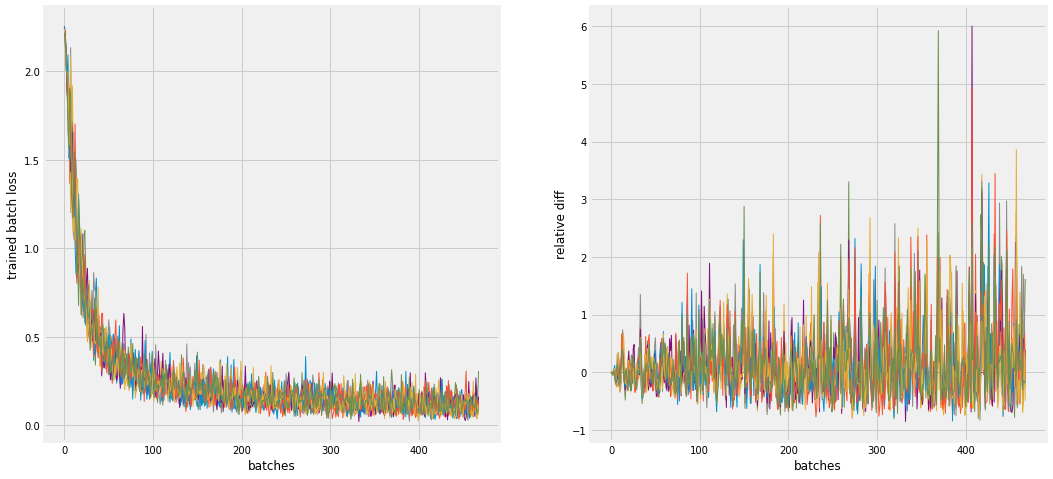

In [18]:
plot_history("train_numpy_random_tf_hash_seeds_fixed_%d.csv")

In [19]:
# train all fixed
!rm -f train_all_fixed.csv
!for i in `seq 10`; do ./mnist_cnn.py -e 1 -r 2 -n 1 -t 4 -a 2 -s -f train_all_fixed_${i}.csv >> train_all_fixed.csv 2>/dev/null; done

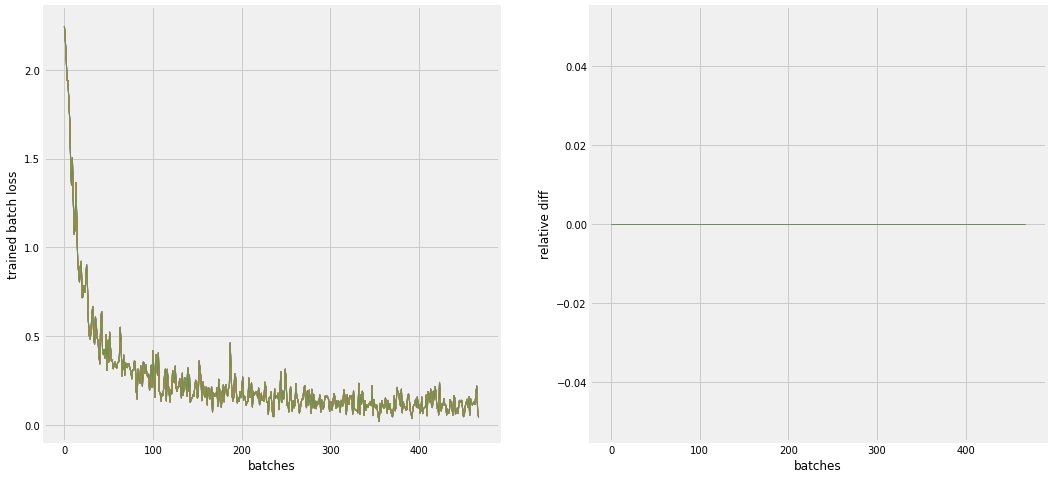

In [20]:
plot_history("train_all_fixed_%d.csv")

## Parallel processing impact

In [21]:
!rm -f train_all_fixed_w4.csv
!for i in `seq 10`; do ./mnist_cnn.py -e 1 -r 2 -n 1 -t 3 -a 1 -w 4 -s -f train_all_fixed_w4_${i}.csv >> train_all_fixed_w4.csv 2>/dev/null; done

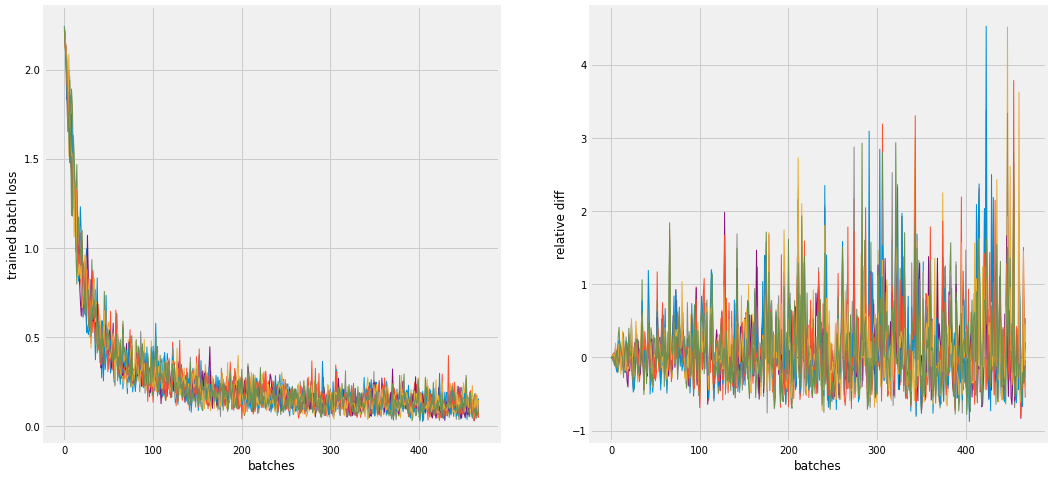

In [22]:
plot_history("train_all_fixed_w4_%d.csv")

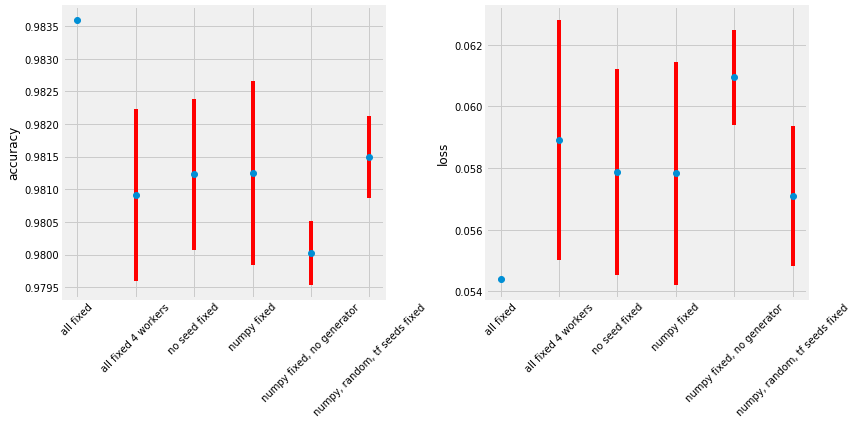

In [23]:
d = {}
d['no seed fixed']= np.loadtxt("train_no_seed_fixed.csv", delimiter=',')
d['numpy fixed'] = np.loadtxt("train_numpy_seed_fixed.csv", delimiter=',')
d['numpy, random, tf seeds fixed'] = np.loadtxt("train_numpy_random_tf_seeds_fixed.csv", delimiter=',')
d['all fixed'] = np.loadtxt("train_all_fixed.csv", delimiter=',')
d['all fixed 4 workers'] = np.loadtxt("train_all_fixed_w4.csv", delimiter=',')
d['numpy fixed, no generator'] = np.loadtxt("train_numpy_seed_fixed_w0.csv", delimiter=',')
plot(d)

## Other sources of randomness

Here is a list of to-do's that I am not going to address in this post:

1. compare the weights directly from different runs
2. change the floating accuracy to float64 or float16.